# KNN Workbook


----
NAME: Changyu Yan     
UID: 304-566-451

----


## Import the appropriate libraries

In [1]:
import numpy as np # for doing most of our calculations
import matplotlib.pyplot as plt# for plotting
from tools.data_utils import load_CIFAR10 # function to load the CIFAR-10 dataset.

# Load matplotlib images inline
%matplotlib inline

# These are important for reloading any code you write in external .py files.
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Set the path to the CIFAR-10 data
cifar10_dir = './tools/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


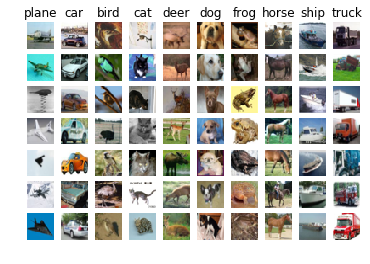

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


# K-nearest neighbors

In the following cells, you will build a KNN classifier and choose hyperparameters via k-fold cross-validation.

In [5]:
# Import the KNN class
from lib import KNN

In [6]:
# Declare an instance of the knn class.
knn = KNN()

# Train the classifier.
#   We have implemented the training of the KNN classifier.
#   Look at the train function in the KNN class to see what this does.
knn.train(X=X_train, y=y_train)

### Questions

(1) Describe what is going on in the function knn.train()

(2) What are the pros and cons of this training step of KNN?


### Answers

In knn.train( ), all we are doing is storing all the data points into the current running program.

Pros:
- Training is very fast    

Cons:
- Storing the training data takes up a lot of space

## KNN prediction

In the following sections, you will implement the functions to calculate the distances of test points to training points, and from this information, predict the class of the KNN.

In [7]:
# Implement the function compute_distances() in the KNN class.

import time
time_start =time.time()

dists_L2 = knn.compute_distances(X=X_test)

print('Time to run code: {}'.format(time.time()-time_start))
print('Frobenius norm of L2 distances: {}'.format(np.linalg.norm(dists_L2, 'fro')))

Time to run code: 51.36733317375183
Frobenius norm of L2 distances: 7906696.077040902


### Really slow code

Note: 
This probably took a while. This is because we use two for loops.  We could increase the speed via vectorization, removing the for loops. Normally it may takes 20-40 seconds.

If you implemented this correctly, evaluating np.linalg.norm(dists_L2, 'fro') should return: ~7906696

### KNN vectorization

The above code took far too long to run.  If we wanted to optimize hyperparameters, it would be time-expensive.  Thus, we will speed up the code by vectorizing it, removing the for loops.

In [8]:
# Implement the function compute_L2_distances_vectorized() in the KNN class.
# In this function, you ought to achieve the same L2 distance but WITHOUT any for loops.
# Note, this is SPECIFIC for the L2 norm.

time_start =time.time()
dists_L2_vectorized = knn.compute_L2_distances_vectorized(X=X_test)
print('Time to run code: {}'.format(time.time()-time_start))
print('Difference in L2 distances between your KNN implementations (should be 0): {}'.format(np.linalg.norm(dists_L2 - dists_L2_vectorized, 'fro')))

Time to run code: 0.42674827575683594
Difference in L2 distances between your KNN implementations (should be 0): 0.0


### Speedup

Depending on your computer speed, you should see a 20-100x speed up from vectorization and no difference in L2 distances between two implementations. 

On our computer, the vectorized form took 0.20 seconds while the naive implementation took 26.88 seconds. 

## Implementing the prediction

Now that we have functions to calculate the distances from a test point to given training points, we now implement the function that will predict the test point labels.

In [9]:
# Implement the function predict_labels in the KNN class.
# Calculate the training error (num_incorrect / total_samples) 
#   from running knn.predict_labels with k=1

y_pred = knn.predict_labels(dists = dists_L2, k = 10)

num_incorrect = 0

for i in range(num_test):
    if y_pred[i] != y_test[i]:
        num_incorrect += 1

error = num_incorrect / num_test

print(error)

0.718


If you implemented this correctly, the error should be: 0.726. This means that the k-nearest neighbors classifier is right 27.4% of the time, which is not great.

# Optimizing KNN hyperparameters

In this section, we'll take the KNN classifier that you have constructed and perform cross-validation to choose a best value of $k$, as well as a best choice of norm.

### Create training and validation folds

First, we will create the training and validation folds for use in k-fold cross validation.

In [10]:
# Create the dataset folds for cross-valdiation.

num_folds = 5
fold_length = round(num_training / num_folds)

X_train_folds = []
y_train_folds = []

# Split the training data into num_folds (i.e., 5) folds.
# X_train_folds is a list, where X_train_folds[i] contains the data points in fold i.
# y_train_folds is also a list, where y_train_folds[i] contains the 
# corresponding labels for the data in X_train_folds[i]

# First, we randomly shuffle the indices
np.random.seed(4)

idx = np.arange(num_training)
np.random.shuffle(idx)
X_train_shuffled = X_train[idx]
y_train_shuffled = y_train[idx]

for i in range(num_folds):
    X_train_folds.append(X_train_shuffled[range(i * fold_length, (i + 1) * fold_length)])

for i in range(num_folds):
    y_train_folds.append(y_train_shuffled[range(i * fold_length, (i + 1) * fold_length)])

X_train_folds = np.asarray(X_train_folds)
y_train_folds = np.asarray(y_train_folds)

In [11]:
def merge_remaining_sublist(my_list, idx_removed):
    result = []
    for i in range(len(my_list)):
        if i != idx_removed:
            result.append(list(my_list[i]))
    return np.concatenate(result, axis = 0)

### Optimizing the number of nearest neighbors hyperparameter.

In this section, we select different numbers of nearest neighbors and assess which one has the lowest k-fold cross validation error.

[0.726  0.746  0.7312 0.7268 0.7184 0.7224 0.722  0.7256 0.724 ]
Set k = 10 and get minimum error as 0.7184000000000001


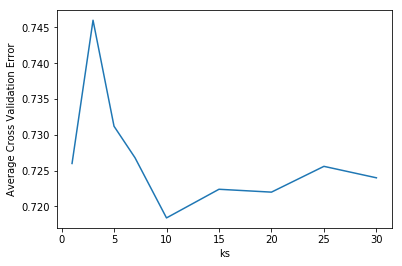

Computation time: 46.78


In [12]:
time_start = time.time()

ks = [1, 3, 5, 7, 10, 15, 20, 25, 30]

# Calculate the cross-validation error for each k in ks, testing
# the trained model on each of the 5 folds.  Average these errors
# together and make a plot of k vs. cross-validation error. Since 
# we are assuming L2 distance here, use the vectorized code!

results = np.zeros(len(ks))

for idx in range(len(ks)):
    errors = []
    for i in range(num_folds):
        knn = KNN()
        
        current_X_train = merge_remaining_sublist(X_train_folds, i)
        current_y_train = merge_remaining_sublist(y_train_folds, i)
        
        current_X_test  = X_train_folds[i]
        current_y_test  = y_train_folds[i]
        
        knn.train(X = current_X_train, y = current_y_train)
        
        dist = knn.compute_L2_distances_vectorized(X = current_X_test)
        y_pred = knn.predict_labels(dist, ks[idx])
        
        # Calculator error for this k_value  
        num_incorrect = 0
        for j in range(num_test):
            if y_pred[j] != current_y_test[j]:
                num_incorrect += 1
        errors.append(num_incorrect / num_test)
    
        
    results[idx] = np.average(errors)
    
print(results)
        

ks_min = ks[np.argsort(results)[0]]
results_min = min(results)

print('Set k = {0} and get minimum error as {1}'.format(ks_min, results_min))
# Plot of k vs. cross-validation error
plt.plot(ks, results)
plt.xlabel('ks')
plt.ylabel('Average Cross Validation Error')
plt.show()

print('Computation time: %.2f'%(time.time()-time_start))

### Questions:

(1) What value of $k$ is best amongst the tested $k$'s?

(2) What is the cross-validation error for this value of $k$?

### Answers:

The best k is k = 10, and its cross-validation error is 0.7184

---

# Evaluating the model on the testing dataset.

Now, given the optimal $k$ and norm you found in earlier parts, evaluate the testing error of the k-nearest neighbors model.

In [13]:
knn = KNN()
knn.train(X=X_train, y=y_train)
dists_L2_vectorized = knn.compute_L2_distances_vectorized(X=X_test)

y_pred = knn.predict_labels(dists = dists_L2, k = 10)

num_incorrect = 0

for i in range(num_test):
    if y_pred[i] != y_test[i]:
        num_incorrect += 1

error = num_incorrect / num_test

print(error)

print('Error rate achieved: {}'.format(error))

0.718
Error rate achieved: 0.718


## Question:

How much did your error improve by cross-validation over naively choosing $k=1$ and using the L2-norm?

## Answer:
Compared to naively choosing k = 1, the error rate has decreased slightly

---

## The End of KNN Workbook